In [1]:
import pandas as pd
import scanpy as sc
from warnings import filterwarnings
filterwarnings('ignore')
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.cm as cm

### Gather performance and plotting

This script is to plot the performance of different models for the cell-line transfer task. 

Train on RPE1 and test on K562

In [2]:
# load in data
cl_train_dataset = 'transfer_cell_line_rpe1_train'
cl_test_dataset = 'transfer_cell_line_k562_essential_test'
use_hvg = True
cl_train_dataset_name = cl_train_dataset + ('_hvg' if use_hvg else '_full')
cl_test_dataset_name = cl_test_dataset + ('_hvg' if use_hvg else '_full')

recon_loss = 'mmd'
null_label = 'zeros' # 'gaussian_normalized' or 'zeros'
tolerance_epoch = 20
mxAlpha = 2.0
n_epochs = 100
latdim_ctrl = 50
latdim_ptb = 50
geneset_num = 50
validation_ratio = 0.1
validation_ood_ratio = 0.15
prior = 'DepMap_GeneEffect'
model_type = 'mvae_attention_vae_14_3'

In [3]:
random_seeds = [8, 9, 10, 11, 12]

### Step 1. Read in all results in csv

In [4]:
control_distribution_path = f'/home/che/perturb-project/git/gene_ptb_prediction/cell_line_transfer/baseline_model/predict_control/{cl_test_dataset_name}'
mean_shift_path = f'/home/che/perturb-project/git/gene_ptb_prediction/cell_line_transfer/baseline_model/mean_shift/{cl_test_dataset_name}'
ft_path = f'/home/che/perturb-project/predict_model/result/rna/{cl_train_dataset_name}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/transfer_cell_line'
train_small_path = f'/home/che/perturb-project/predict_model/result/rna/{cl_test_dataset_name}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/fine_tune'
train_large_path = f'/home/che/perturb-project/predict_model/result/rna/{cl_test_dataset_name}/latdim_ctrl_{latdim_ctrl}_latdim_ptb_{latdim_ptb}_geneset_num_{geneset_num}/fine_tune_1500'

In [8]:
control_distribution_df = pd.DataFrame()
mean_shift_df = pd.DataFrame()
ft_ctrl_df = pd.DataFrame()
ft_small_df = pd.DataFrame()
train_small_df = pd.DataFrame()
train_large_df = pd.DataFrame()

for seed in random_seeds:

    # load in control distribution results
    control_distribution_path_temp = f'{control_distribution_path}/random_seed_{seed}/ctrl_summary_results.csv'
    control_distribution_df_temp = pd.read_csv(control_distribution_path_temp)
    control_distribution_df_temp['random_seed'] = seed
    control_distribution_df_temp['model_type'] = 'Control distribution'
    control_distribution_df_temp['model_path'] = control_distribution_path_temp
    control_distribution_df = pd.concat([control_distribution_df, control_distribution_df_temp])

    # load in mean shift results
    mean_shift_path_temp = f'{mean_shift_path}/random_seed_{seed}/ctrl_summary_results.csv'
    mean_shift_df_temp = pd.read_csv(mean_shift_path_temp)
    mean_shift_df_temp['random_seed'] = seed
    mean_shift_df_temp['model_type'] = 'Mean shift'
    mean_shift_df_temp['model_path'] = mean_shift_path_temp
    mean_shift_df = pd.concat([mean_shift_df, mean_shift_df_temp])

    # load in fine-tune on control results
    ft_path_temp = f'{ft_path}/recon_loss_{recon_loss}/null_label_{null_label}/epochs_{n_epochs}/tolerance_epochs_{tolerance_epoch}/mxAlpha_{mxAlpha}/val_{validation_ratio}_ood_{validation_ood_ratio}/random_seed_12'
    pattern = f'{ft_path_temp}/{prior}_{model_type}_run*'
    ft_path_temp = glob.glob(pattern)
    # assert len(ft_path_temp) == 1, f'Error: {pattern}'
    ft_path_temp = ft_path_temp[0]
    print('read in', ft_path_temp)
    ft_ctrl_path_temp = f'{ft_path_temp}/ctrl_ft/best_model_epochs_9_rand_seed_{seed}/summary_results.csv'
    ft_ctrl_df_temp = pd.read_csv(ft_ctrl_path_temp)
    ft_ctrl_df_temp['random_seed'] = seed
    ft_ctrl_df_temp['model_type'] = 'Fine-tune on control'
    ft_ctrl_df_temp['model_path'] = ft_ctrl_path_temp
    ft_ctrl_df = pd.concat([ft_ctrl_df, ft_ctrl_df_temp])

    # load in fine-tune on small set of perturbations results
    ft_small_path_temp = f'{ft_path_temp}/fine_tune_100/best_model_epochs_50_rand_seed_{seed}/summary_results.csv'
    ft_small_df_temp = pd.read_csv(ft_small_path_temp)
    ft_small_df_temp['random_seed'] = seed
    ft_small_df_temp['model_type'] = 'Fine-tune on 100 perturbations'
    ft_small_df_temp['model_path'] = ft_small_path_temp
    ft_small_df = pd.concat([ft_small_df, ft_small_df_temp])

    # load in train on small set of perturbations results
    train_small_path_temp = f'{train_small_path}/recon_loss_{recon_loss}/null_label_{null_label}/epochs_{n_epochs}/tolerance_epochs_{tolerance_epoch}/mxAlpha_{mxAlpha}/val_{validation_ratio}_ood_{validation_ood_ratio}/random_seed_{seed}'
    pattern = f'{train_small_path_temp}/{prior}_{model_type}_run*'
    train_small_path_temp = glob.glob(pattern)
    assert len(train_small_path_temp) == 1, f'Error: {pattern}'
    train_small_path_temp = train_small_path_temp[0]
    train_small_path_temp = f'{train_small_path_temp}/best_model_summary_evaluations.csv'
    train_small_df_temp = pd.read_csv(train_small_path_temp)
    train_small_df_temp['random_seed'] = seed
    train_small_df_temp['model_type'] = 'Train on 100 perturbations'
    train_small_df_temp['model_path'] = train_small_path_temp
    train_small_df = pd.concat([train_small_df, train_small_df_temp])

    # load in train on large set of perturbations results
    train_large_path_temp = f'{train_large_path}/recon_loss_{recon_loss}/null_label_{null_label}/epochs_{n_epochs}/tolerance_epochs_{tolerance_epoch}/mxAlpha_{mxAlpha}/val_{validation_ratio}_ood_{validation_ood_ratio}/random_seed_{seed}'
    pattern = f'{train_large_path_temp}/{prior}_{model_type}_run*'
    train_large_path_temp = glob.glob(pattern)
    # assert len(train_large_path_temp) == 1, f'Error: {pattern}'
    try:
        train_large_path_temp = train_large_path_temp[0]
        train_large_path_temp = f'{train_large_path_temp}/best_model_summary_evaluations.csv'
        train_large_df_temp = pd.read_csv(train_large_path_temp)
        train_large_df_temp['random_seed'] = seed
        train_large_df_temp['model_type'] = 'Train on 1500 perturbations'
        train_large_df_temp['model_path'] = train_large_path_temp
        train_large_df = pd.concat([train_large_df, train_large_df_temp])
    except:
        print(f'Error: {pattern}')

assert control_distribution_df.shape[0] == mean_shift_df.shape[0] == ft_ctrl_df.shape[0] == ft_small_df.shape[0] == train_small_df.shape[0] == len(random_seeds)

read in /home/che/perturb-project/predict_model/result/rna/transfer_cell_line_rpe1_train_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/transfer_cell_line/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_3_run1730258323
read in /home/che/perturb-project/predict_model/result/rna/transfer_cell_line_rpe1_train_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/transfer_cell_line/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_3_run1730258323
read in /home/che/perturb-project/predict_model/result/rna/transfer_cell_line_rpe1_train_hvg/latdim_ctrl_50_latdim_ptb_50_geneset_num_50/transfer_cell_line/recon_loss_mmd/null_label_zeros/epochs_100/tolerance_epochs_20/mxAlpha_2.0/val_0.1_ood_0.15/random_seed_12/DepMap_GeneEffect_mvae_attention_vae_14_3_run1730258323
read in /home/che/perturb-project/predict_m

In [14]:
# rename mmd_de to mmd and rmse_de to rmse
ft_ctrl_df.rename(columns={'mmd_de': 'mmd', 'rmse_de': 'rmse'}, inplace=True)
ft_small_df.rename(columns={'mmd_de': 'mmd', 'rmse_de': 'rmse'}, inplace=True)

In [15]:
control_distribution_df['mmd'].mean(), ft_ctrl_df['mmd'].mean(), ft_small_df['mmd'].mean(), train_small_df['mmd'].mean(), train_large_df['mmd'].mean()

(0.5896515787534897,
 0.5496553790579207,
 0.48162907871400823,
 0.5419931251106738,
 0.47067248844333615)

In [16]:
control_distribution_df['mmd'].std(), ft_ctrl_df['mmd'].std(), ft_small_df['mmd'].std(), train_small_df['mmd'].std(), train_large_df['mmd'].std()

(0.001026923036132276,
 0.007086196315910325,
 0.0021552169943820326,
 0.009158042604356723,
 0.01003258097490696)

In [17]:
ft_ctrl_df

,mmd,mmd_whole,r2_de,r2_whole,l2_de,mse_de,mse_whole,rmse,rmse_whole,pearsonr_de,...,rmse_change,rmse_change_whole,pearsonr_change,pearsonr_change_whole,fraction,fraction_whole,note,random_seed,model_type,model_path
0,0.544001,0.430509,0.925349,0.973654,1.414443,0.050947,0.006474,0.200032,0.075708,0.976020,...,0.200032,0.075708,0.241688,0.123237,0.593918,0.528577,Using top 50 marker genes,8,Fine-tune on control,/home/che/perturb-project/predict_model/result...
0,0.546063,0.427771,0.924992,0.974691,1.415620,0.051426,0.006218,0.200199,0.074373,0.976619,...,0.200199,0.074373,0.254612,0.130287,0.597878,0.529848,Using top 50 marker genes,9,Fine-tune on control,/home/che/perturb-project/predict_model/result...
0,0.559515,0.434512,0.923018,0.972828,1.446026,0.053768,0.006675,0.204499,0.076914,0.975889,...,0.204499,0.076914,0.225876,0.114053,0.581658,0.526379,Using top 50 marker genes,10,Fine-tune on control,/home/che/perturb-project/predict_model/result...
0,0.543937,0.429258,0.925751,0.974127,1.411198,0.051008,0.006356,0.199574,0.075076,0.976363,...,0.199574,0.075076,0.246002,0.123088,0.596874,0.528594,Using top 50 marker genes,11,Fine-tune on control,/home/che/perturb-project/predict_model/result...
0,0.554761,0.427932,0.923179,0.974852,1.440396,0.053720,0.006177,0.203703,0.074214,0.976281,...,0.203703,0.074214,0.236396,0.114921,0.582936,0.526603,Using top 50 marker genes,12,Fine-tune on control,/home/che/perturb-project/predict_model/result...


### Step 2. Put results together in one table and save as a csv file

In [20]:
columns_selected = ['random_seed', 'model_type', 'mmd', 'rmse', 'model_path']

In [21]:
all_results_df = pd.concat([control_distribution_df[columns_selected], 
                            mean_shift_df[columns_selected],
                            ft_ctrl_df[columns_selected],
                            ft_small_df[columns_selected],
                            train_small_df[columns_selected],
                            train_large_df[columns_selected]], axis=0)
all_results_df.head(2)

,random_seed,model_type,mmd,rmse,model_path
0,8,Control distribution,0.589311,0.217580,/home/che/perturb-project/git/gene_ptb_predict...
0,9,Control distribution,0.590645,0.217663,/home/che/perturb-project/git/gene_ptb_predict...


In [22]:
all_results_df['model_type'].unique()

array(['Control distribution', 'Mean shift', 'Fine-tune on control',
       'Fine-tune on 100 perturbations', 'Train on 100 perturbations',
       'Train on 1500 perturbations'], dtype=object)

In [23]:
all_results_df['model_name'] = all_results_df['model_type']

# replace mvae_attention_vae_14_3 with A-VAE
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Control distribution', 'Control\ndistribution', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Mean shift', 'Mean\nshift', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Fine-tune on control', 'Fine-tuned\non control', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Fine-tune on 100 perturbations', 'Fine-tuned on 100\nperturbations', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Train on 100 perturbations', 'Trained on 100\nperturbations', regex=False)
all_results_df['model_name'] = all_results_df['model_name'].str.replace('Train on 1500 perturbations', 'Trained on 1500\nperturbations', regex=False)
all_results_df.head(2)

,random_seed,model_type,mmd,rmse,model_path,model_name
0,8,Control distribution,0.589311,0.217580,/home/che/perturb-project/git/gene_ptb_predict...,Control\ndistribution
0,9,Control distribution,0.590645,0.217663,/home/che/perturb-project/git/gene_ptb_predict...,Control\ndistribution


In [24]:
# save into a csv file 
result_folder = f'{cl_train_dataset_name}'
result_folder += f'/{cl_test_dataset_name}'
result_folder += f'/null_label_{null_label}'
result_folder += f'/tolerance_epoch_{tolerance_epoch}'
result_folder += '/best_model'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
print(result_folder)

all_results_df.to_csv(f'{result_folder}/results.csv', index=False)

transfer_cell_line_rpe1_train_hvg/transfer_cell_line_k562_essential_test_hvg/null_label_zeros/tolerance_epoch_20/best_model


### Step 3. Plot results

In [25]:
grouped_data = all_results_df.groupby("model_name").agg(
    mmd_mean=("mmd", "mean"),
    mmd_std=("mmd", "std"),
    # r2_mean=("r2", "mean"),
    # r2_std=("r2", "std"),
    rmse_mean=("rmse", "mean"),
    rmse_std=("rmse", "std"),
    # rmse_change_mean=("rmse_change", "mean"),
    # rmse_change_std=("rmse_change", "std"),
    # pearsonr_change_mean=("pearsonr_change", "mean"),
    # pearsonr_change_std=("pearsonr_change", "std"),
    # fraction_mean=("fraction", "mean"),
    # fraction_std=("fraction", "std"),
    mmd_values=("mmd", lambda x: list(x)),
    # r2_values=("r2", lambda x: list(x)),
    rmse_values=("rmse", lambda x: list(x)),
    # rmse_change_values=("rmse_change", lambda x: list(x)),
    # pearsonr_change_values=("pearsonr_change", lambda x: list(x)),
    # fraction_values=("fraction", lambda x: list(x)),
).reset_index()
grouped_data

,model_name,mmd_mean,mmd_std,rmse_mean,rmse_std,mmd_values,rmse_values
0,Control\ndistribution,0.589652,0.001027,0.217698,0.000128,"[0.5893109806615763, 0.590644915132756, 0.5895...","[0.21757953, 0.21766347, 0.21758746, 0.2177876..."
1,Fine-tuned\non control,0.549655,0.007086,0.201601,0.002310,"[0.5440009066485539, 0.5460626053152915, 0.559...","[0.2000324668223843, 0.2001989517123879, 0.204..."
2,Fine-tuned on 100\nperturbations,0.481629,0.002155,0.180093,0.001077,"[0.4841614985239726, 0.4804333305817719, 0.482...","[0.1818593821840771, 0.1796849495877875, 0.180..."
3,Mean\nshift,0.604818,0.000859,0.211477,0.000120,"[0.6052606823722159, 0.6048335052785218, 0.603...","[0.21155815, 0.21144319, 0.21137905, 0.2116421..."
4,Trained on 100\nperturbations,0.541993,0.009158,0.201877,0.003109,"[0.5511616046062211, 0.5408383934910094, 0.527...","[0.2046428883597203, 0.2024642844211242, 0.196..."
5,Trained on 1500\nperturbations,0.470672,0.010033,0.175846,0.003918,"[0.4757437671364738, 0.4562680041773, 0.481907...","[0.1785098625342785, 0.1701367981166831, 0.180..."


In [26]:
grouped_data.to_csv(f'{result_folder}/sumamry_results.csv', index=False)

In [27]:
desired_order_baseline = [ 'Control\ndistribution', 
                          'Mean\nshift',
                          'Fine-tuned\non control',
                          'Fine-tuned on 100\nperturbations', 
                          'Trained on 100\nperturbations', 
                          'Trained on 1500\nperturbations']

### Plot MMD (distribution loss)

In [28]:
model_colors_baseline = {
            'Control\ndistribution': 'darkgrey',
            'Mean\nshift': '#bdd7e7',
            'Fine-tuned\non control': '#8fcf91',
            'Fine-tuned on 100\nperturbations': '#74c476',
            'Trained on 100\nperturbations': '#ffb732',
            'Trained on 1500\nperturbations': '#ffa500',
        }

In [29]:
np.random.seed(0)
jiggers = np.random.normal(0, 0.05, size=len(grouped_data['mmd_values'].values[0]))
jiggers

array([0.08820262, 0.02000786, 0.0489369 , 0.11204466, 0.0933779 ])

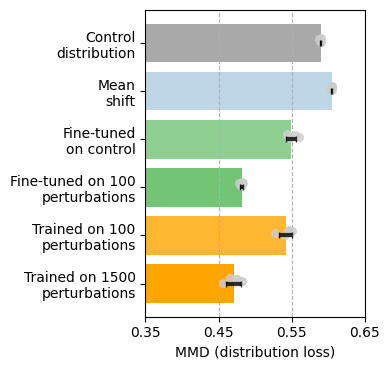

In [30]:
# Simplified bar plot for MMD
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Prepare the DataFrame for MMD
mmd_df = grouped_data.dropna(subset=['mmd_mean'])
desired_order = desired_order_baseline
model_colors = model_colors_baseline
mmd_df = mmd_df[mmd_df['model_name'].isin(desired_order)]
mmd_df['model_name'] = pd.Categorical(mmd_df['model_name'], categories=desired_order[::-1], ordered=True)
mmd_df = mmd_df.sort_values('model_name')

# Customize x-axis limits and ticks based on dataset
fig_x = 4
fig_y = 3.8

x_min = 0.35
x_max = 0.65
bar_width = 0.8

# Draw figure
fig, ax = plt.subplots(figsize=(fig_x, fig_y))
indices = np.arange(len(mmd_df))
colors = mmd_df['model_name'].map(model_colors)

# Plot bars for MMD with individual colors
ax.barh(indices, mmd_df['mmd_mean'],color=colors, zorder = 1, height=bar_width)
# Plot individual dots for each MMD value
for i, model_name in enumerate(mmd_df['model_name']):
    model_values = mmd_df[mmd_df['model_name'] == model_name]['mmd_values'].values[0]
    jittered_y = indices[i] + jiggers
    ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
# Plot error bars for MMD on top (top layer)
ax.errorbar(mmd_df['mmd_mean'], indices, xerr=mmd_df['mmd_std'], fmt='none', 
            ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

# Set ticks and labels
ax.set_yticks(indices)
ax.set_yticklabels(mmd_df['model_name'])
ax.set_xlabel('MMD (distribution loss)')
ax.set_xlim(x_min, x_max)
ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
ax.grid(False, axis='x', linestyle='--')

# Save plot
plt.tight_layout()
plt.savefig(f'{result_folder}/mmd_plot.png', dpi=300)
# save svg format
plt.savefig(f'{result_folder}/mmd_plot.svg', format='svg')
plt.show()

### Plot RMSE (feature means)

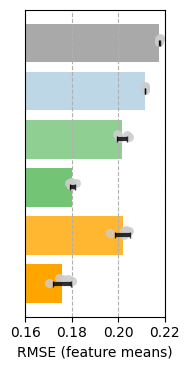

In [31]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 10

# Prepare the DataFrame for rmse
rmse_df = grouped_data.dropna(subset=['rmse_mean'])
desired_order = desired_order_baseline
model_colors = model_colors_baseline
rmse_df = rmse_df[rmse_df['model_name'].isin(desired_order)]
rmse_df['model_name'] = pd.Categorical(rmse_df['model_name'], categories=desired_order[::-1], ordered=True)
rmse_df = rmse_df.sort_values('model_name')

# Customize x-axis limits and ticks based on dataset
fig_x = 2
fig_y = 3.8
x_min=0.16
x_max=0.22
bar_width = 0.8

# Set up figure
fig, ax = plt.subplots(figsize=(fig_x, fig_y))

# Set bar width
indices = np.arange(len(rmse_df))
colors = rmse_df['model_name'].map(model_colors)

# Plot bars
ax.barh(indices, rmse_df['rmse_mean'],color=colors, zorder = 1)
# Plot individual dots
for i, model_name in enumerate(rmse_df['model_name']):
    model_values = rmse_df[rmse_df['model_name'] == model_name]['rmse_values'].values[0]
    jittered_y = indices[i] + jiggers
    ax.scatter(model_values, jittered_y, color='#cccccc', alpha=0.8, s=30, zorder=2)
# Plot error bars
ax.errorbar(rmse_df['rmse_mean'], indices, xerr=rmse_df['rmse_std'], fmt='none', 
            ecolor='black', elinewidth=3, capsize=2, zorder=3, alpha=0.8)

# Set ticks and labels
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_xlabel('RMSE (feature means)')
ax.set_xlim(x_min, x_max)
ax.set_xticks(np.round(np.linspace(x_min, x_max, 4), 2))
ax.grid(False, axis='x', linestyle='--')

# Save plot
plt.tight_layout()
plt.savefig(f'{result_folder}/rmse_plot.png', dpi=300)
# save svg format
plt.savefig(f'{result_folder}/rmse_plot.svg', format='svg')
plt.show()